In [1]:
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
df_game_events = pd.read_csv('all_game_events.csv')
df_game_events

,season,game time,period,period time,game id,home team,away team,goal,team shot,goal home coordinates,coordinates,shooter,goalie,shot type,empty net,strength,home goal,away goal,rebound,shot distance
0,2016,2017-04-12T23:00:00Z,1,00:16,2016030111,MTL,NYR,False,MTL,[89 0],"[-8.0, -36.0]",Dwight King,Henrik Lundqvist,Wrist Shot,NaN,NaN,0,0,False,88.639720
1,2016,2017-04-12T23:00:00Z,1,01:56,2016030111,MTL,NYR,False,NYR,[89 0],"[85.0, -6.0]",Rick Nash,Carey Price,Wrist Shot,NaN,NaN,0,0,False,7.211103
2,2016,2017-04-12T23:00:00Z,1,02:04,2016030111,MTL,NYR,False,MTL,[89 0],"[-69.0, -35.0]",Max Pacioretty,Henrik Lundqvist,Wrist Shot,NaN,NaN,0,0,False,40.311289
3,2016,2017-04-12T23:00:00Z,1,03:40,2016030111,MTL,NYR,False,MTL,[89 0],"[-55.0, -17.0]",Dwight King,Henrik Lundqvist,Slap Shot,NaN,NaN,0,0,False,38.013156
4,2016,2017-04-12T23:00:00Z,1,04:56,2016030111,MTL,NYR,False,MTL,[89 0],"[-58.0, -28.0]",Paul Byron,Henrik Lundqvist,Wrist Shot,NaN,NaN,0,0,False,41.773197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361216,2020,2021-05-09T02:30:00Z,3,19:57,2020020868,SJS,ARI,False,SJS,[-89 0],"[71.0, -16.0]",Noah Gregor,Adin Hill,Backhand,NaN,NaN,4,4,False,24.083189
361217,2020,2021-05-09T02:30:00Z,4,00:33,2020020868,SJS,ARI,False,SJS,[89 0],"[-68.0, -14.0]",Erik Karlsson,Adin Hill,Wrist Shot,NaN,NaN,4,4,False,25.238859
361218,2020,2021-05-09T02:30:00Z,4,00:57,2020020868,SJS,ARI,False,ARI,[89 0],"[56.0, 11.0]",Conor Garland,Alexei Melnichuk,Wrist Shot,NaN,NaN,4,4,False,34.785054
361219,2020,2021-05-09T02:30:00Z,4,01:46,2020020868,SJS,ARI,False,ARI,[89 0],"[73.0, 6.0]",Conor Garland,Alexei Melnichuk,Wrist Shot,NaN,NaN,4,4,False,17.088007


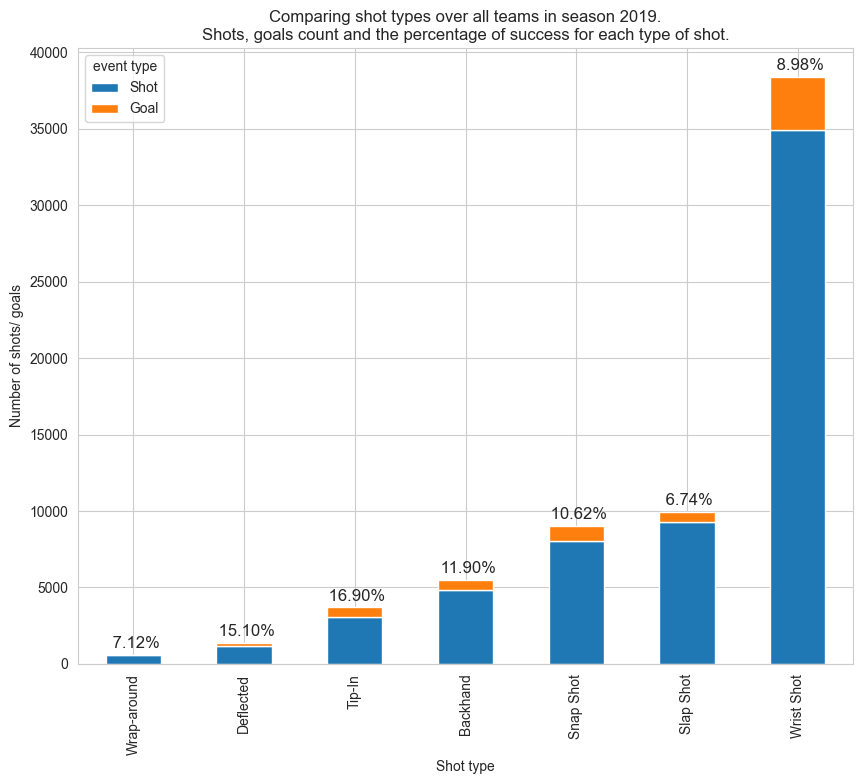

In [3]:
def plot_shot_goal(df_game_events, season="2019"):
    # create a new column indicating event type
    df_game_events['event type'] = df_game_events['goal'].apply(lambda x: 'Goal' if x else 'Shot')
    
    # pivot
    df_shot_goal = df_game_events[df_game_events['season'].astype(str)==season].groupby(['event type','shot type']).size().reset_index().pivot(columns='event type', index='shot type', values=0)
    df_shot_goal = df_shot_goal.reindex(columns=['Shot','Goal'])
    df_shot_goal.sort_values(['Shot','Goal'], ascending = [True, True], inplace=True)
    
    # plot bar chart
    ax = df_shot_goal.plot(kind='bar', stacked=True,figsize=(10, 8),
                          title=f"Comparing shot types over all teams in season {season}.\nShots, goals count and the percentage of success for each type of shot.")
    
    # analyse sucess rate of different shot types
    df_total_shot_goal = df_shot_goal['Shot']+df_shot_goal['Goal']
    goal_percentage = df_shot_goal['Goal']/df_total_shot_goal
    for idx, p in enumerate(ax.patches):
        if(idx>=7):
            continue
        height = p.get_height() + ax.patches[idx+7].get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 450, f'{goal_percentage[idx] * 100 : .2f}%', size=12,
                    ha="center")
        
    plt.xlabel('Shot type')
    plt.ylabel('Number of shots/ goals')
    
plot_shot_goal(df_game_events, "2019")

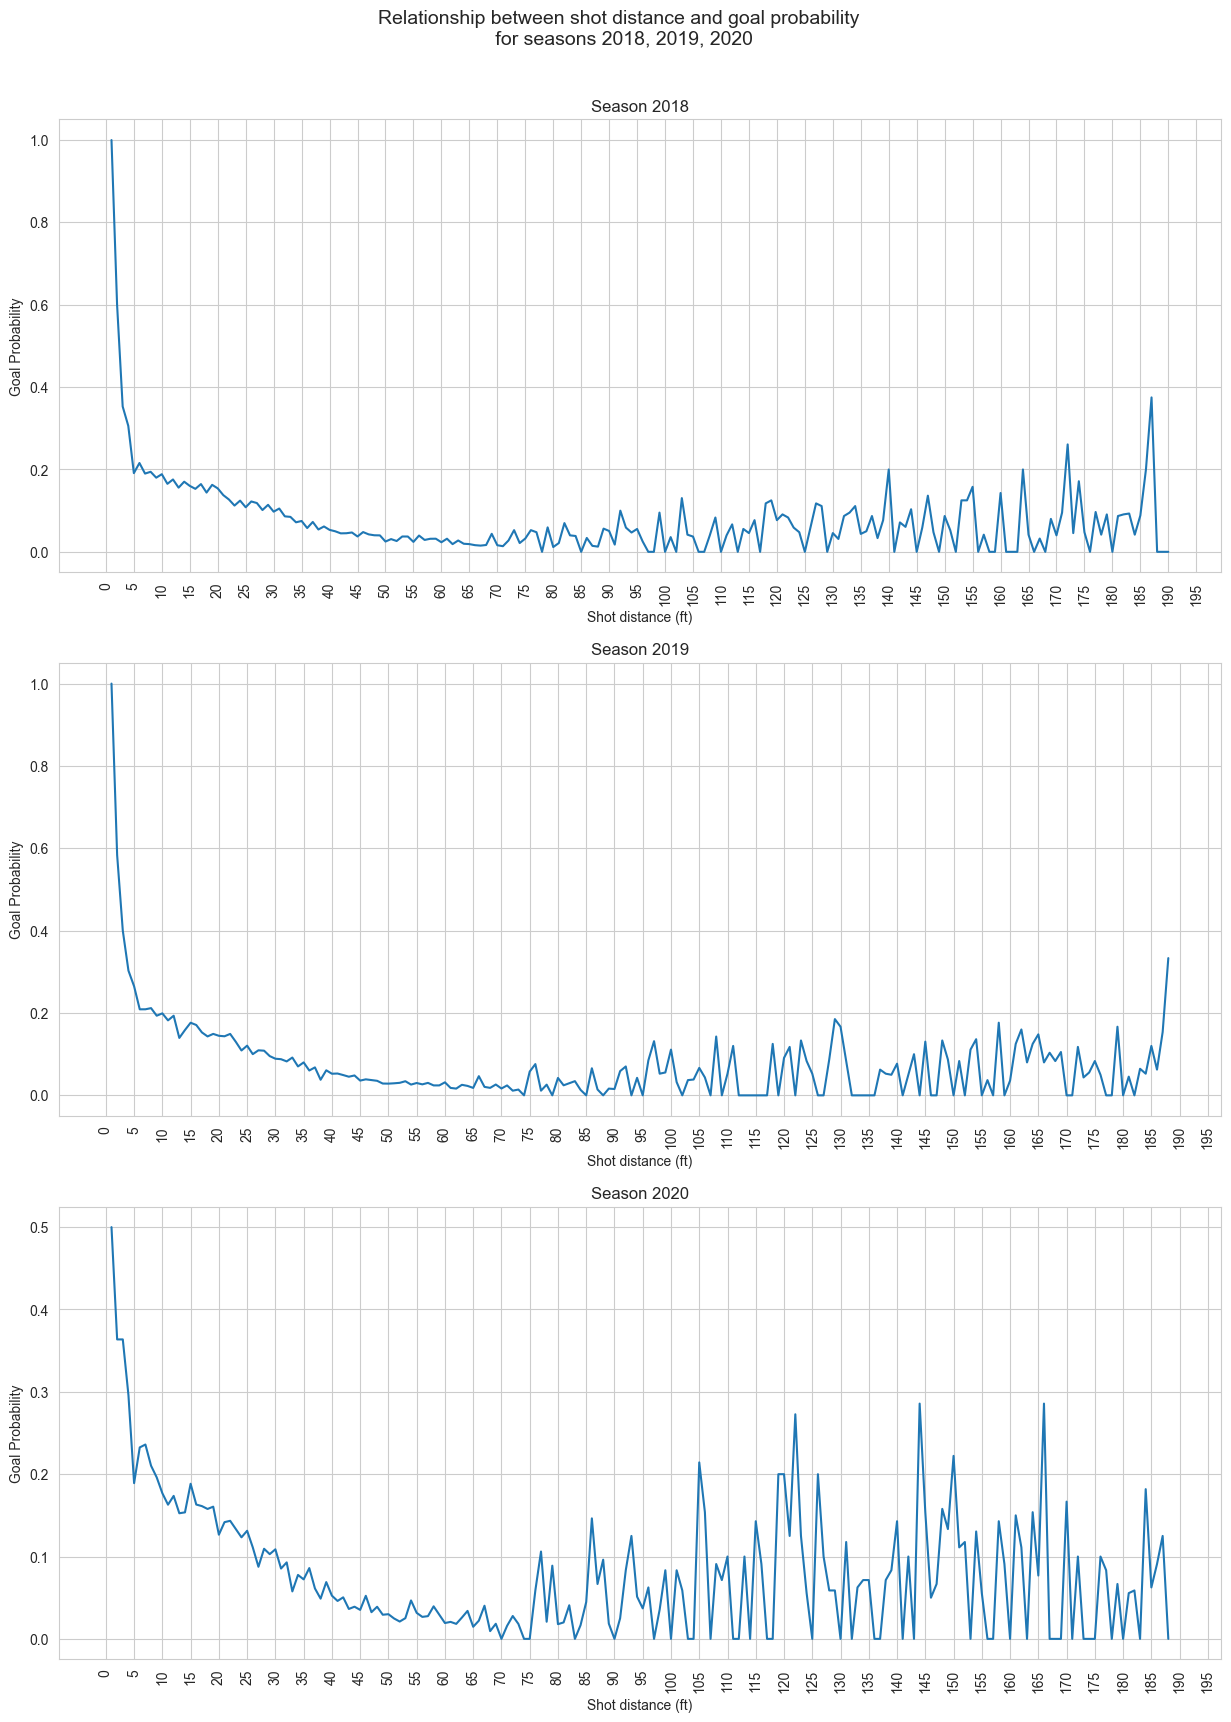

In [4]:
def distance_vs_goal(df_game_events, seasons=['2018','2019','2020'], round_distance = 1):
    """
    """
    df_game_events['shot distance'] = df_game_events['shot distance'].round(0)
    fig = plt.figure(figsize=(15, 20))
    
    for season_idx, season in enumerate(seasons):
        plt.subplot(3, 1, season_idx + 1)
        df_game_events_season = df_game_events[df_game_events['season'].astype(str)==season]
        df_game_events_season = df_game_events_season.copy()
        df_game_events_season['shot distance'] = df_game_events_season['shot distance'].apply(lambda x: int(x/round_distance)*round_distance)
        df_game_events_season = df_game_events_season.groupby(['shot distance'])['goal'].mean().to_frame().reset_index()
        ax = sns.lineplot(x='shot distance', y='goal', data=df_game_events_season)
        plt.title(f'Season {season}')
        ax.set_axisbelow(True)
        plt.xticks(np.arange(0, 200, 5), rotation=90)
        plt.xlabel('Shot distance (ft)')
        plt.ylabel('Goal Probability')
        
    plt.suptitle(f'Relationship between shot distance and goal probability \n for seasons {seasons[0]}, {seasons[1]}, {seasons[2]}', size=14,
                     y=0.935)
        
distance_vs_goal(df_game_events, ['2018','2019','2020'])

shot distance,1,2,3,4,5,6,7,8,9,10,...,179,180,181,182,183,184,185,186,187,188
shot type,,,,,,,,,,,,,,,,,,,,,
Backhand,0.0,0.000000,0.625000,0.459459,0.277778,0.217105,0.169903,0.170588,0.189621,0.200000,...,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
Deflected,0.0,1.000000,0.000000,0.571429,0.625000,0.307692,0.318841,0.175258,0.182609,0.139241,...,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
Slap Shot,0.0,0.000000,0.000000,0.333333,0.500000,0.125000,0.100000,0.360000,0.368421,0.210526,...,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
Snap Shot,0.0,1.000000,0.000000,0.666667,0.333333,0.200000,0.243902,0.262295,0.200000,0.209302,...,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
Tip-In,0.0,1.000000,0.500000,0.428571,0.400000,0.301724,0.230769,0.245763,0.184810,0.184818,...,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
Wrap-around,0.0,0.000000,0.090909,0.017857,0.129032,0.090090,0.071429,0.042857,0.100000,0.055556,...,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
Wrist Shot,1.0,0.571429,0.500000,0.346154,0.259740,0.205882,0.226415,0.234043,0.198413,0.216509,...,0.214286,0.0,0.05,0.0,0.068966,0.071429,0.130435,0.083333,0.25,0.5


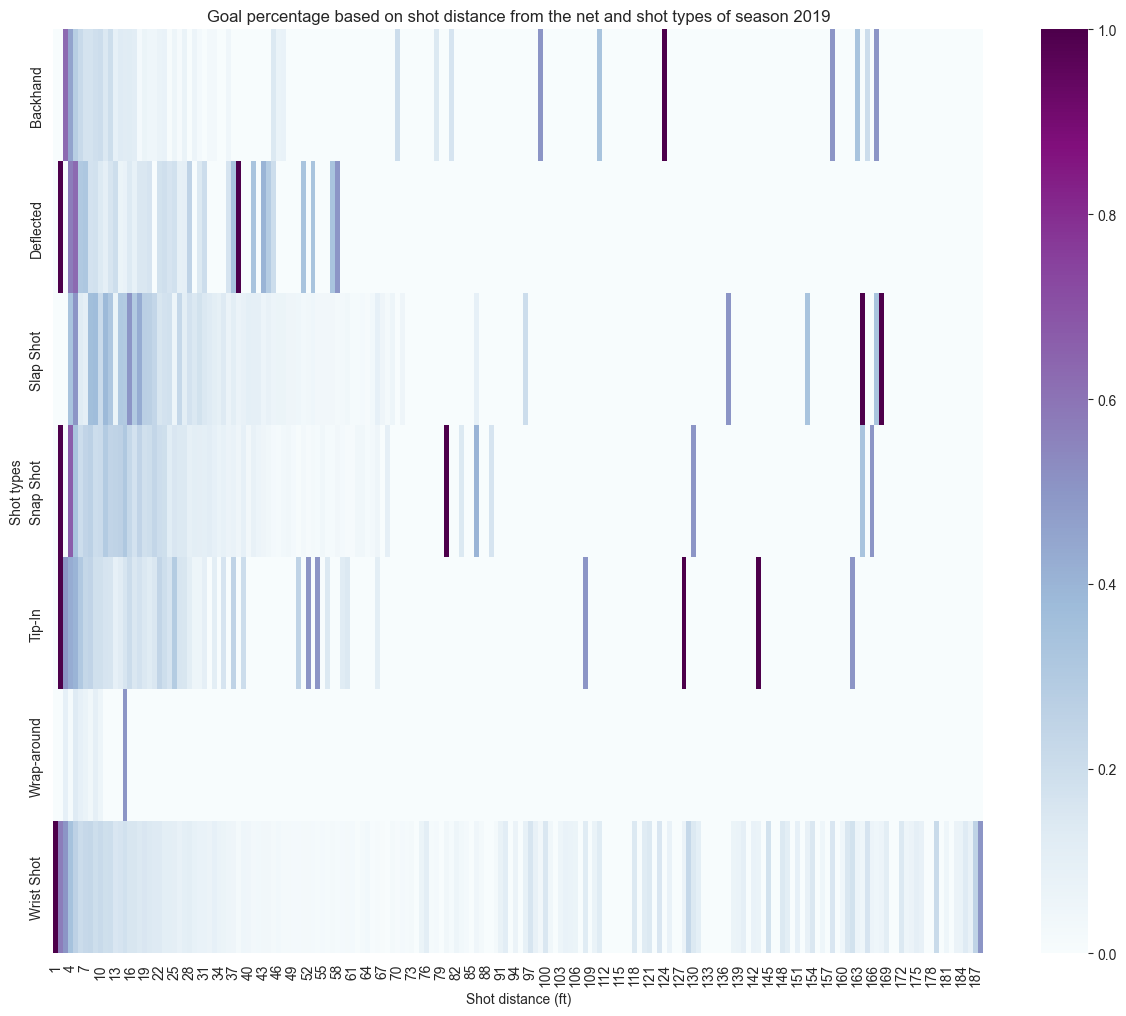

In [6]:
def distance_and_type_vs_goal(df_game_events, season="2019", round_distance=3):
    df_game_events['shot distance'] = df_game_events['shot distance'].round(0).astype(int)
    df_game_events_season = df_game_events[df_game_events['season'].astype(str)==season]
    df_game_events_season = df_game_events_season.copy()
    df_game_events_season['shot distance'] = df_game_events_season['shot distance'].apply(lambda x: int(x/round_distance)*round_distance)
    df_filtered = df_game_events_season.groupby(["shot distance", "shot type"])["goal"].mean().to_frame().reset_index()
    df_pivot = df_filtered.pivot(columns="shot distance", index="shot type", values='goal').fillna(0)
    fig = plt.figure(figsize=(15, 12))
    sns.heatmap(df_pivot,cmap="BuPu")
    plt.xlabel('Shot distance (ft)')
    plt.ylabel('Shot types')
    plt.title(f'Goal percentage based on shot distance from the net and shot types of season {season}')
    return df_pivot

abc = distance_and_type_vs_goal(df_game_events, "2019", 1)
abc